# Imports

In [1]:
import os
import numpy as np
import scipy as sp
import seaborn as sns
import sklearn
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

In [2]:
import splitfolders
#splitfolders.ratio('C:/Users/Krow/Documents/Uni/PI/archive_main/asl_alphabet_train/asl_alphabet_train/', output="C:/Users/Krow/Documents/Uni/PI/dataset_main/", seed=1337, ratio=(.6, .2, .2))
#splitfolders.ratio('C:/Users/Krow/Documents/Uni/PI/archive_simple/asl_dataset/', output="C:/Users/Krow/Documents/Uni/PI/dataset_sec/", seed=1337, ratio=(0, 0.5,0.5)) 

# Consts

In [3]:
#batch_size = 32
image_size = 128
target_dim = (image_size, image_size)
nm_classes  = 5

#image_count = 87000
#train_dir_real  = 'C:/Users/Krow/Documents/Uni/PI/dataset_main/train'
#val_dir_real  = 'C:/Users/Krow/Documents/Uni/PI/dataset_main/val/'
#test_dir_real = 'C:/Users/Krow/Documents/Uni/PI/dataset_main/test/'
train_dir_synth = 'C:/Users/Krow/Documents/Uni/PI/dataset_sec/train_synth/'

train_dir_real  = 'C:/Users/Krow/Documents/Uni/PI/dataset_sec/train'
val_dir_real  = 'C:/Users/Krow/Documents/Uni/PI/dataset_sec/val/'
test_dir_real = 'C:/Users/Krow/Documents/Uni/PI/dataset_sec/test/'


# Load Dataset

In [4]:
from imgaug import augmenters as iaa

aug1 = iaa.GaussianBlur(sigma=(0, 2.0))
aug2 = iaa.AdditiveGaussianNoise(0,0.05 * 255)

def additional_augmenation(image):
    #image = aug1.augment_image(image)
    image = aug1.augment_image(image)
    return image

In [5]:
#Augmentation
# rotation_range=30, fill_mode='nearest'
# width_shift_range=0.2, height_shift_range=0.2
# horizontal_flip=True, vertical_flip=True
# brightness_range=[0.5,1.1]
# zoom_range=0.3
# preprocessing_function = iaa.GaussianBlur(sigma=(0, 3.0))

train_image_generator = ImageDataGenerator(rescale=1./255,
rotation_range=5,
#width_shift_range=0.05, height_shift_range=0.05,
#brightness_range=[0.95,1.05],
#zoom_range=[1,1.2]
#preprocessing_function = additional_augmenation
)
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir_synth, shuffle=False, target_size = target_dim)

Found 534 images belonging to 5 classes.


In [6]:
validation_image_generator = ImageDataGenerator(rescale=1./255,
rotation_range=5)
validation_data_gen = validation_image_generator.flow_from_directory(directory=val_dir_real, shuffle=False, target_size = target_dim)

Found 140 images belonging to 5 classes.


In [7]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory=test_dir_real, shuffle=False, target_size = target_dim)

Found 210 images belonging to 5 classes.


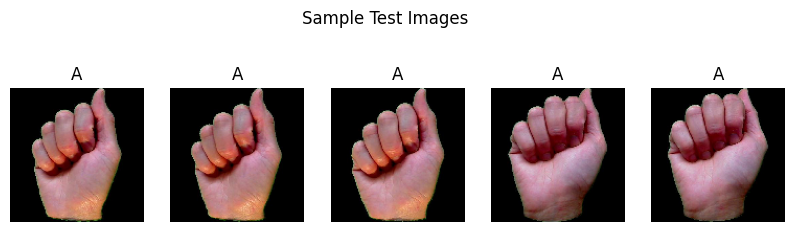

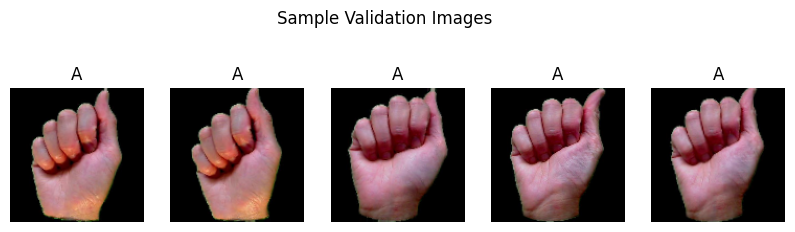

In [8]:
def display_samples(data_gen, title):
    classes = dict()
    for key,val in data_gen.class_indices.items():
        classes[val]= key

    sample_images, sample_labels = next(data_gen)

    plt.figure(figsize=(10,3))
    plt.subplots_adjust(hspace=0.5)
    for n in range(5):
        plt.subplot(1,5,n+1)
        plt.imshow(sample_images[n])
        plt.title(classes[np.argmax(sample_labels[n])])
        plt.axis("off")
        _ = plt.suptitle(title)

#display_samples(train_data_gen, "Sample Training Images")
display_samples(test_data_gen, "Sample Test Images")
display_samples(validation_data_gen, "Sample Validation Images")


In [9]:
num_classes = len(validation_data_gen.class_indices)

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build([None, image_size, image_size, 3])  # Batch input shape.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              54336736  
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 54,344,421
Trainable params: 7,685
Non-trainable params: 54,336,736
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
metrics=['acc'])

In [11]:
train_steps_per_epoch = np.ceil(validation_data_gen.samples/validation_data_gen.batch_size)
#val_steps_per_epoch = np.ceil(validation_data_gen.samples/validation_data_gen.batch_size)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, min_delta=0.001)

epochs = 100

history = model.fit(validation_data_gen,
                    epochs=epochs,
                    steps_per_epoch=train_steps_per_epoch,
                    #validation_data=validation_data_gen,
                    #validation_steps=val_steps_per_epoch,
                    verbose=1,
                    callbacks=[early_stop]
)

Epoch 1/100
5/5 [==============================] - 16s 79ms/step - loss: 3.4870 - acc: 0.1357
Epoch 2/100
5/5 [==============================] - 1s 109ms/step - loss: 1.8452 - acc: 0.3571
Epoch 3/100
5/5 [==============================] - 1s 89ms/step - loss: 1.2913 - acc: 0.4500
Epoch 4/100
5/5 [==============================] - 1s 109ms/step - loss: 0.7202 - acc: 0.7000
Epoch 5/100
5/5 [==============================] - 1s 91ms/step - loss: 0.5633 - acc: 0.7571
Epoch 6/100
5/5 [==============================] - 0s 103ms/step - loss: 0.3801 - acc: 0.8429
Epoch 7/100
5/5 [==============================] - 1s 110ms/step - loss: 0.2484 - acc: 0.9429
Epoch 8/100
5/5 [==============================] - 1s 94ms/step - loss: 0.2155 - acc: 0.9571
Epoch 9/100
5/5 [==============================] - 1s 87ms/step - loss: 0.1921 - acc: 0.9500
Epoch 10/100
5/5 [==============================] - 0s 86ms/step - loss: 0.1262 - acc: 1.0000
Epoch 11/100
5/5 [==============================] - 1s 92ms/step

In [12]:
class_names = np.empty([len(test_data_gen.class_indices)], dtype=object, order="C")
for key, val in test_data_gen.class_indices.items():
    class_names[val] = key
    
test_data_gen.reset()
predicted_batch = model.predict(test_data_gen)

7/7 [==============================] - 3s 95ms/step


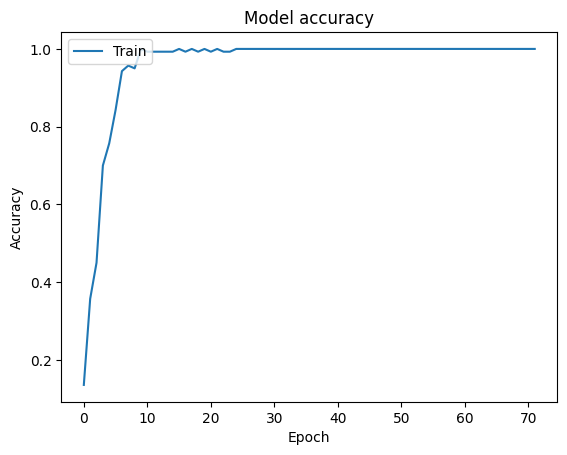

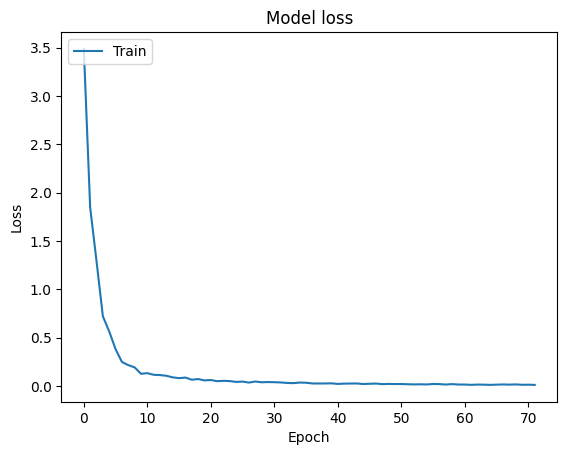

In [13]:
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(test_data_gen)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

7/7 [==============================] - 3s 67ms/step - loss: 0.0503 - acc: 0.9905
Test accuracy: 0.9904761910438538
Test loss: 0.05030835419893265


Text(0.5, 1.0, 'Accuracy Score: 0.9904761904761905')

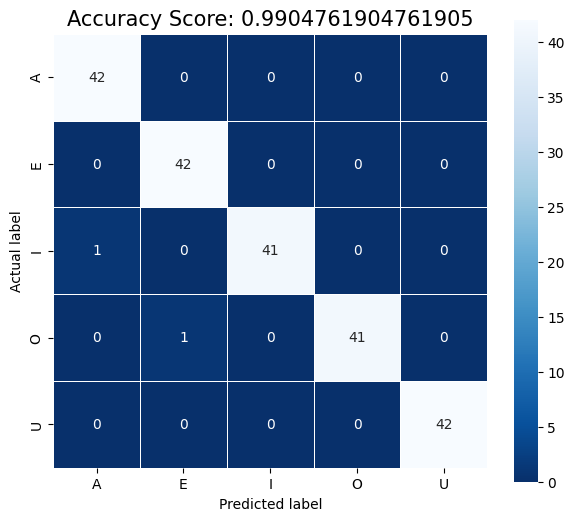

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classes = ['A', 'E', 'I', 'O', 'U']

predicted_id = np.argmax(predicted_batch, axis=1)

cm = confusion_matrix(test_data_gen.classes, predicted_id)
plt.figure(figsize=(7,6))
ax = sns.heatmap(cm,annot=True, fmt='.0f', linewidths=.5, square=True,cmap='Blues_r')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(test_data_gen.classes,predicted_id))
plt.title(all_sample_title,size=15)

In [16]:
#model.save('asl_sec_full_synth_resnet_96_19.h5')

# Dataset Visualization

# Model & Criterion

# Model Fitting

# Prediction

# Save Model

In [17]:
#model.save('asl_model_synth_B.h5')

# Load Model to avoid retraining

In [18]:
# load model
#model = tf.keras.models.load_model('asl_model_synth_B.h5')

# Load real data

# Predictions: Real Data